## To Classify between dogs and cats using CNN architecture in

CNN receives an input feature map: a three-dimensional matrix where the size of the first two dimensions corresponds to the length and width of the images in pixels. The size of the third dimension is 3 (corresponding to the 3 channels of a color image: red, green, and blue). The CNN comprises a stack of modules, each of which performs three operations.
> * Convolution
* MaxPooling
* ReLU

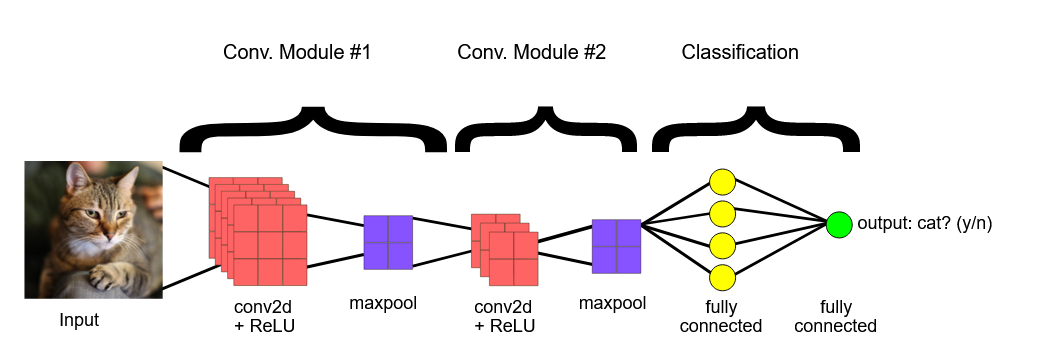

Steps-

1. Import the data
2. Visualize the data
3. Preprocessing on the data
4. Creating the model
5. Tuning the model
6. Saving/Loading the model

In [1]:
# importing requirements
import os
import tqdm
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import random

import tensorflow as tf
tf.__version__

'2.13.0'

In [2]:
from torch import cuda, bfloat16

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device

'cuda:0'

### Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/Datasets/dogs_cats_kaggle.zip"

Streaming output truncated to the last 5000 lines.
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5489.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/549.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5490.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5491.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5492.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5493.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5494.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5495.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5496.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5497.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5498.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5499.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/55.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/550.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5500.jpg  
  inflating: kagglecats

In [5]:
data_dir = "/content/kagglecatsanddogs_3367a/PetImages"

#### Aternate Methods

In [6]:
# def resize(input_image, size):
#     return tf.image.resize(input_image, size)

# def central_crop(input_image):
#     image = resize(input_image, [176, 176])
#     return tf.image.central_crop(image, central_fraction=0.84)

# def random_rotation(input_image):
#   angles = np.random.randint(0, 3, 1)
#   return tf.image.rot90(input_image, k=angles[0])

# def random_jitter(input_image):
#   # Resize it to 176 x 176 x 3
#   image = resize(input_image, [176, 176])
#   # Randomly Crop to 150 x 150 x 3
#   image = central_crop(image)
#   # Randomly rotation
#   image = random_rotation(image)
#   # Randomly mirroring
#   image = tf.image.random_flip_left_right(image)
#   return image

# def normalize(input_image):
#     mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
#     input_image = input_image / mid - 1
#     return input_image

In [7]:
# def load_image_train(image_file, label):
#     image, label = load(image_file, label)
#     image = random_jitter(image)
#     image = normalize(image)
#     return image, label

# def load_image_val(image_file, label):
#     image, label = load(image_file, label)
#     image = central_crop(image)
#     image = normalize(image)
#     return image, label

In [8]:
# ! pip install python_splitter
# import python_splitter
# python_splitter.split_from_folder("SOURCE_FOLDER", train=0.5, test=0.3, val=0.2)

In [9]:
from glob import glob

for files in glob(f'{data_dir}/Cat/*.db'):
  os.remove(files)

for files in glob(f'{data_dir}/Dog/*.db'):
  os.remove(files)

In [10]:
# find corrupted files and remove them
# os.remove(files)

In [11]:
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)

    return image, label

In [12]:
path = f"/content/kagglecatsanddogs_3367a/PetImages/Dog/1.jpg"
image, label = load(path, 1)

image.shape

TensorShape([500, 327, 3])

In [13]:
# image

In [14]:
os.chdir(data_dir)
%pwd

'/content/kagglecatsanddogs_3367a/PetImages'

In [15]:
input_path = []
label = []

for class_name in os.listdir(data_dir):
    for path in os.listdir(data_dir+"/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/11516.jpg 1


In [16]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/8024.jpg,0
1,PetImages/Dog/585.jpg,1
2,PetImages/Cat/3993.jpg,0
3,PetImages/Dog/840.jpg,1
4,PetImages/Dog/7835.jpg,1


#### Visualizing the data

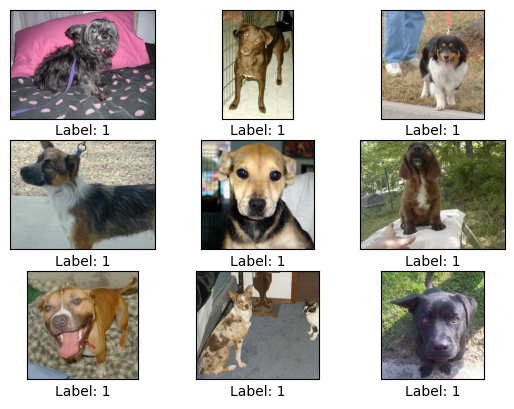

In [17]:
for i in range(9):
  path = f"/content/kagglecatsanddogs_3367a/PetImages/Dog/{i}.jpg"
  plt.subplot(330+1+i)
  image, label = load(path, 1)
  plt.imshow(image/255.0)
  plt.xlabel(f"Label: {label}")
  plt.xticks([])
  plt.yticks([])

plt.show()

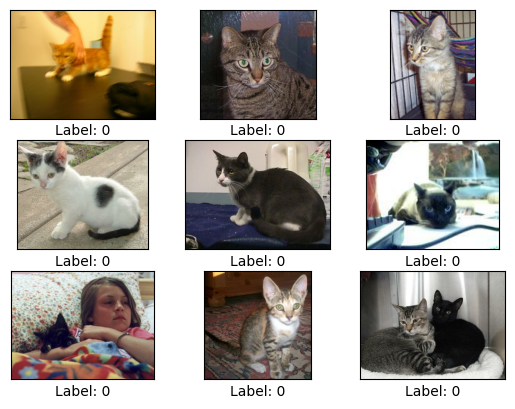

In [18]:
for i in range(9):
  path = f"/content/kagglecatsanddogs_3367a/PetImages/Cat/{i}.jpg"
  plt.subplot(330+1+i)
  image, label = load(path, 0)
  plt.imshow(image/255.0)
  plt.xlabel(f"Label: {label}")
  plt.xticks([])
  plt.yticks([])

plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24959 entries, 0 to 24958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  24959 non-null  object
 1   label   24959 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.1+ KB


In [20]:
df.isna().sum()

images    0
label     0
dtype: int64

In [21]:
df.label.unique()

array([0, 1])

In [22]:
# df.groupby(label).count() # 0 is dog, 1 is cat

In [23]:
df["label"] = df["label"].astype(np.object)

### Creating the Data Pipeline

In [24]:
df.head()

,images,label
0,PetImages/Cat/8024.jpg,0
1,PetImages/Dog/585.jpg,1
2,PetImages/Cat/3993.jpg,0
3,PetImages/Dog/840.jpg,1
4,PetImages/Dog/7835.jpg,1


In [25]:
%pwd

'/content/kagglecatsanddogs_3367a/PetImages'

In [26]:
! pip install python_splitter
import python_splitter
python_splitter.split_from_folder(data_dir, train=0.8, test=0.1, val=0.1)

✅Checking SOURCE directory...
0.8 0.1 0.1
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [28]:
train_dir = "/content/kagglecatsanddogs_3367a/PetImages/Train_Test_Folder/train"
train_iterator = train_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode='binary')

Found 19967 images belonging to 2 classes.


In [29]:
# len(train_iterator)

In [30]:
val_generator = ImageDataGenerator(
    rescale = 1./255,
)

In [31]:
val_dir = "/content/kagglecatsanddogs_3367a/PetImages/Train_Test_Folder/val"
val_iterator = val_generator.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=64,
                                                class_mode='binary')

Found 2496 images belonging to 2 classes.


In [32]:
test_generator = ImageDataGenerator(
    rescale = 1./255,
)

In [33]:
test_dir = "/content/kagglecatsanddogs_3367a/PetImages/Train_Test_Folder/test"
test_iterator = test_generator.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                batch_size=64,
                                                class_mode='binary')

Found 2496 images belonging to 2 classes.


In [34]:
# train_iterator[0]

In [35]:
train_iterator[0][0][0].shape

(224, 224, 3)

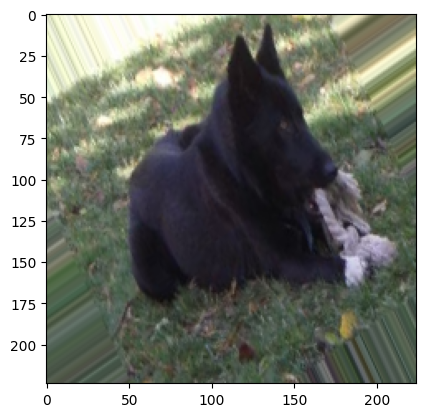

In [36]:
plt.imshow(train_iterator[0][0][0])

### Model Building

In [37]:
from tensorflow.keras.metrics import Precision, Recall

In [38]:
# set random seed
tf.random.set_seed(42)

# create the model
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
      tf.keras.layers.MaxPool2D((2,2)),

      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])


#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ["accuracy"],)

In [39]:
# Visualize the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [40]:
train_iterator

In [41]:
train_length=19967
batch_size=128
steps_per_epoch = train_length // batch_size
steps_per_epoch

155

In [42]:
#fit the model
history = model.fit(train_iterator,
          epochs=8,
          validation_data=val_iterator,
          verbose=1,
          steps_per_epoch=steps_per_epoch,
          batch_size=256
          )

Epoch 1/8
155/155 [==============================] - 159s 940ms/step - loss: 0.6701 - accuracy: 0.6220 - val_loss: 0.6083 - val_accuracy: 0.6558
Epoch 2/8
155/155 [==============================] - 146s 943ms/step - loss: 0.5813 - accuracy: 0.6845 - val_loss: 0.5406 - val_accuracy: 0.7264
Epoch 3/8
155/155 [==============================] - 148s 956ms/step - loss: 0.5476 - accuracy: 0.7167 - val_loss: 0.5458 - val_accuracy: 0.7047
Epoch 4/8
155/155 [==============================] - 157s 1s/step - loss: 0.5278 - accuracy: 0.7349 - val_loss: 0.4633 - val_accuracy: 0.7829
Epoch 5/8
155/155 [==============================] - 152s 979ms/step - loss: 0.5063 - accuracy: 0.7456 - val_loss: 0.4552 - val_accuracy: 0.7756
Epoch 6/8
155/155 [==============================] - 148s 957ms/step - loss: 0.4882 - accuracy: 0.7611 - val_loss: 0.4462 - val_accuracy: 0.7817
Epoch 7/8
155/155 [==============================] - 145s 936ms/step - loss: 0.4754 - accuracy: 0.7730 - val_loss: 0.4365 - val_accur

### Visualizing the loss and accuracy curves of the current model

In [43]:
def plot_accuracy_loss (history):
    """
      Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("Training vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()


    # Plot Loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Training vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

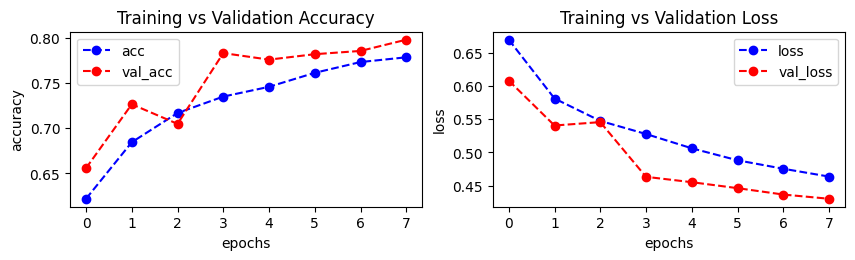

In [44]:
plot_accuracy_loss(history)

### Evaluating the model on unseen data (testing set)

In [45]:
# evaluate the model
model.evaluate(test_iterator)

39/39 [==============================] - 7s 171ms/step - loss: 0.4248 - accuracy: 0.8157


[0.4248388707637787, 0.8157051205635071]

In [46]:
y_probs=model.predict(test_iterator[0][0])
y_probs[:10]

2/2 [==============================] - 1s 13ms/step


array([[0.02008325],
       [0.40240982],
       [0.05259894],
       [0.54329854],
       [0.99256855],
       [0.46887055],
       [0.9851944 ],
       [0.49247336],
       [0.17937142],
       [0.20656836]], dtype=float32)

In [ ]:
y_preds = tf.round(y_probs)
y_preds[:10]

In [48]:
from sklearn.metrics import classification_report
print(classification_report(test_iterator[0][1].astype(np.int32), y_preds))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        29
           1       0.77      0.69      0.73        35

    accuracy                           0.72        64
   macro avg       0.72      0.72      0.72        64
weighted avg       0.73      0.72      0.72        64



### Visualizing the predictions of model on unseen data

In [49]:
# prettify the confusion matrix (sklearns plot confusion matrix)
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_prettier(y_true, y_preds, figsize=(10,10), classes = None, text_size=10):

  """
  A function to plot the confusion matrix is a more
  visually understandable manner inspred by the plot_confusion_matrix function offered by sklearn
   """

  # create the confusion matrix
  cm = confusion_matrix(y_true, tf.round(y_preds))
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  # lets prettify the plotting
  fig, ax = plt.subplots(figsize=figsize)
  # cerate matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # label the axes
  ax.set(title="Confusion martix",
        xlabel="Perdicted labels",
        ylabel="Actual Label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # set x_axis labels to the bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # adjust ylabel size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # set the threshold
  threshold = (cm.max()+cm.min()) / 2

  # plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i,j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=15)


In [50]:
class_names=["dog","cat"]

In [51]:
y_preds.shape

TensorShape([64, 1])

In [52]:
test_iterator[0][1].astype(np.int32)[:10]

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0], dtype=int32)

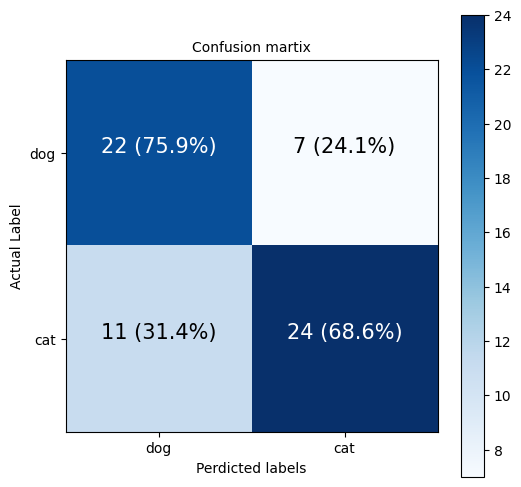

In [53]:
plot_confusion_matrix_prettier(y_true=test_iterator[0][1].astype(np.int32), y_preds=y_preds, classes=class_names, figsize=(6,6) )

### Saving current model

In [54]:
# saving the model
model.save("Dogs_Cats_CNN_model_1.h5")

## Using Transfer learning - VGG16 model

**VGG16 Architecture**

VGG is an acronym for the Visual Geometric Group from Oxford University and VGG-16 is a network with 16 layers proposed by the Visual Geometric Group. These 16 layers contain the trainable parameters and there are other layers also like the Max pool layer but those do not contain any trainable parameters. This

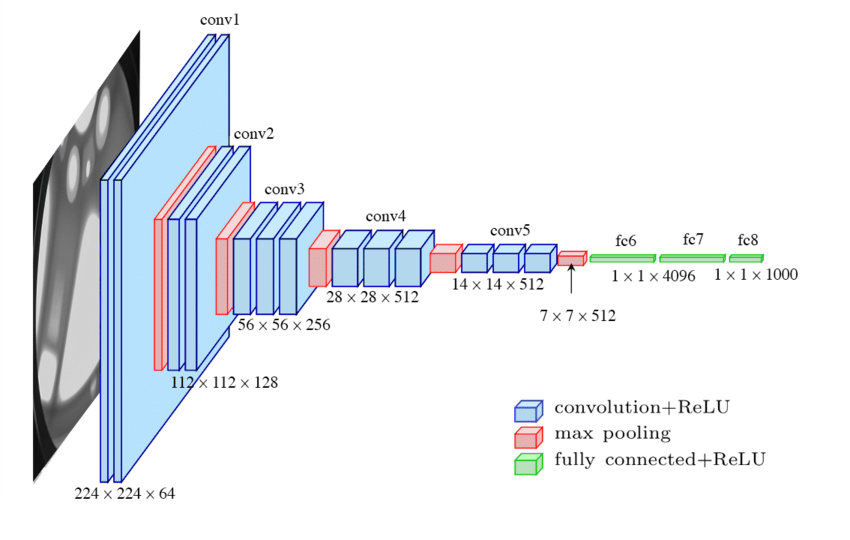

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model

model_vgg16 = VGG16(weights="imagenet", # loading pre-trained weights
                    include_top=False,
                    input_shape=tf.squeeze(test_iterator[0][0][0]).shape)

#freeze the weights
model_vgg16.trainable = False

In [ ]:
for layer in model_vgg16.layers:
   layer.trainable=False

In [57]:
# input shape
model_vgg16.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [58]:
# ouput shape
model_vgg16.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [59]:
# fine tuning
x = tf.keras.layers.GlobalMaxPooling2D()(model_vgg16.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model_vgg16.input,outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              metrics=["accuracy"])

In [61]:
steps_per_epoch = 155

In [ ]:
# fit the model
history = model.fit(train_iterator,
                    epochs=3,
                    validation_data=val_iterator,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    batch_size=64)

Epoch 1/3
155/155 [==============================] - 177s 1s/step - loss: 0.7119 - accuracy: 0.7873 - val_loss: 0.2257 - val_accuracy: 0.9067
Epoch 2/3
155/155 [==============================] - 160s 1s/step - loss: 0.3393 - accuracy: 0.8497 - val_loss: 0.2123 - val_accuracy: 0.9123
Epoch 3/3
155/155 [==============================] - 155s 994ms/step - loss: 0.3178 - accuracy: 0.8616 - val_loss: 0.2238 - val_accuracy: 0.9014
